In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-18 10:00:12.855605: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [3]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
fit_dir = tempfile.mkdtemp()

In [5]:
tournament_games = historical_record.latest_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games

,match_date,player_1,character_1,win,character_2,player_2,public
0,2014-07-06 00:00:00,Jengajam,menelker,0,setsuki,fodazd,True
1,2014-07-06 00:00:00,MadKing,quince,1,setsuki,CKR,True
2,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
3,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
4,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
...,...,...,...,...,...,...,...
120301,2015-09-07 19:11:01,DarkSephiroth,menelker,0,valerie,BONZAI,False
120302,2015-09-07 19:09:31,Kirandio,degrey,0,menelker,pfiidude,False
120303,2015-09-07 19:17:11,hartley,valerie,0,rook,EricF,False
120304,2015-09-07 19:17:43,DarkSephiroth,menelker,0,valerie,BONZAI,False


In [6]:
games = historical_record.augment_dataset(games)

Constructing PC category


In [10]:
min_games = 0
warmup = 500
samples = 1000

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    games, games.win.astype('int'), random_state=42
)

In [12]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [13]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_only.PCGlicko}

In [14]:
model_names = [
    'full',
    # 'mu',
    # 'elo',
    'mu_elo',
    # 'pc_elo',
    'mu_pc_elo',
    # 'mu_pc_elo_vol',
    # 'mu_pc_elo_c',
    # 'glicko',
    # 'mu_glicko',
    # 'pc_glicko',
    # 'mu_pc_glicko',
]
models = {model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples) for model_name in model_names}

In [15]:
numpy.min(X_train[['player_1', 'player_2', 'match_date']].values[:, -1])

Timestamp('2013-06-16 01:10:29')

In [19]:
from sklearn import set_config
set_config(transform_output="pandas")

In [22]:
models['full'].pipeline(transform__elo__initial_time=games.match_date.min(), transform__pc_elo__initial_time=games.match_date.min(), full__min_games=min_games, full__warmup=warmup, full__samples=samples).fit(X_train, y_train)

             player_1         player_2          match_date
98987       Vujak (2)  FenixOfTheAshes 2015-05-14 03:10:57
43981     Mine Wizard         ingerul9 2013-10-29 16:15:57
75937          Tridat           Nashun 2014-10-07 05:27:37
10801       Corroyeur       pickles672 2016-03-19 00:00:00
24014  flagrantangles         Knifight 2020-05-16 00:00:00
...               ...              ...                 ...
15234    mysticjuicer   flagrantangles 2016-12-14 00:00:00
24851  vengefulpickle           Cypher 2021-01-13 00:00:00
8622         Jengajam        deluks917 2015-10-18 00:00:00
26138         sraloth        Remy77077 2013-06-17 23:50:58
41074        ingerul9           friiik 2013-09-24 18:06:31

[90229 rows x 3 columns]
            player_character_1     player_character_2          match_date
98987         Vujak (2)-geiger   FenixOfTheAshes-rook 2015-05-14 03:10:57
43981       Mine Wizard-midori       ingerul9-valerie 2013-10-29 16:15:57
75937          Tridat-menelker            Na

,elo__prob,pc_elo__prob,remainder__character_1,remainder__win,remainder__character_2,remainder__public
98987,0.394121,0.479054,geiger,0,rook,False
43981,0.440173,0.508170,midori,1,valerie,False
75937,0.522239,0.405935,menelker,0,rook,False
10801,0.541461,0.423101,argagarg,1,bbb,True
24014,0.526849,0.589766,quince,1,vendetta,True
...,...,...,...,...,...,...
15234,0.578161,0.482639,quince,0,quince,True
24851,0.496800,0.442604,argagarg,0,midori,True
8622,0.495898,0.369822,geiger,1,zane,True
26138,0.415547,0.466503,jaina,0,onimaru,False


AttributeError: 'DataFrame' object has no attribute 'player_1'

In [77]:
for model_name in model_names:
    models[model_name].fit(
        X_train,
        y_train,
        # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
    )

Compiling...
Compilation time =  0:00:01.286421
Sampling...
Sampling time =  0:00:05.436601
Transforming variables...
Transformation time =  0:02:36.030756
Compiling...
Compilation time =  0:00:01.082890
Sampling...
Sampling time =  0:00:04.879248
Transforming variables...
Transformation time =  0:02:16.695346
Compiling...
Compilation time =  0:00:01.105518
Sampling...
Sampling time =  0:00:04.884058
Transforming variables...
Transformation time =  0:02:18.038703


In [78]:
pred_test = {
    model_name: models[model_name].predict_proba(X_test)[:, 1]
    for model_name in model_names
}

In [79]:
df_pred_test = pandas.DataFrame(pred_test)

In [80]:
df_pred_test.set_index(X_test.index)
pandas.concat([X_test, df_pred_test.set_index(X_test.index)], axis=1).sort_values('pc_elo_weight')[['player_1', 'character_1', 'win', 'character_2', 'player_2', 'pc_elo_1', 'pc_elo_2', 'pc_elo_weight'] + [model_name for model_name in model_names]]

,player_1,character_1,win,character_2,player_2,pc_elo_1,pc_elo_2,pc_elo_weight,full,mu_elo,mu_pc_elo
39346,Request,menelker,1,zane,deluks917,1288.136384,1611.234943,0.000000,0.202458,0.242977,0.155525
16870,MysticDeadman,gwen,1,setsuki,BD_Corro,1302.927744,1690.565916,0.044986,0.225426,0.276259,0.197702
38953,Request,menelker,0,vendetta,Nashun,1299.284943,1457.081461,0.100526,0.324409,0.348179,0.321429
57898,Gilrad,quince,0,setsuki,Spartacvs,1314.268587,1649.000852,0.111360,0.197530,0.225501,0.230917
40704,Request,menelker,0,rook,ingerul9,1315.504544,1612.677049,0.128494,0.249404,0.302322,0.164152
...,...,...,...,...,...,...,...,...,...,...,...
5358,Fivec,setsuki,1,zane,cpat,1693.383156,1699.158283,1.870651,0.409201,0.406699,0.395441
119415,Nashun,rook,0,vendetta,enomus,1709.167105,1709.893358,1.914455,0.615057,0.630565,0.544408
106255,Nashun,rook,1,setsuki,Fivec,1702.456263,1713.422289,1.920216,0.446997,0.433306,0.544363
56747,friiik,lum,1,menelker,tipzntrix,1711.998969,1721.561554,1.962641,0.460027,0.463696,0.471384


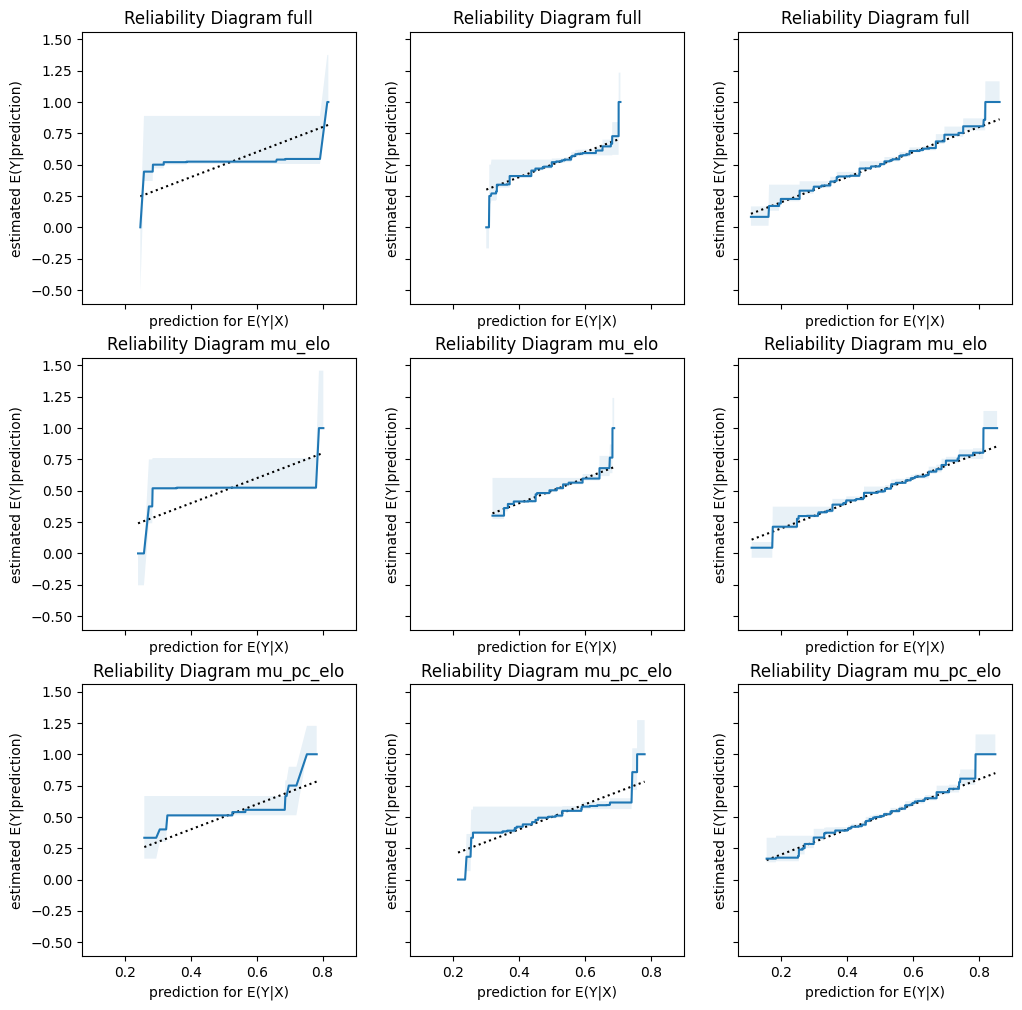

In [81]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram
fig, axes = plt.subplots(ncols=3, nrows=len(model_names), figsize=(12, 4*len(model_names)), sharex=True, sharey=True)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()
similar_elo_matches = ((X_test.elo_1 - X_test.elo_2).abs() < 50).to_numpy()

for i, model_name in enumerate(model_names):
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][0],
    )
    plot_reliability_diagram(
        y_obs=y_test[similar_elo_matches],
        y_pred=df_pred_test[model_name][similar_elo_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][1],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][2],
    )

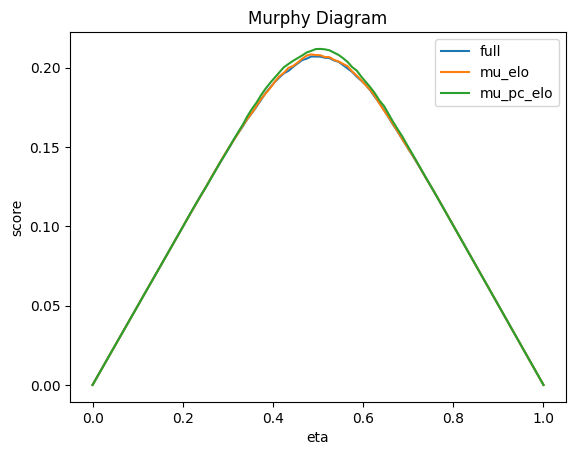

In [82]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [83]:
from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

df_list = []
for model_name in model_names:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]


model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""full""",0.00052,0.012149,0.249995,0.238366
"""mu_elo""",0.000549,0.011815,0.249995,0.238728
"""mu_pc_elo""",0.000465,0.009692,0.249995,0.240768


In [84]:
import arviz
for model in ['full', 'mu_elo', 'mu_pc_elo']:
    print(model)
    display(arviz.summary(models[model].inf_data_))

full


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[argagarg-argagarg],0.001,0.502,-0.888,1.022,0.005,0.010,10864.0,2659.0,1.0
mu[argagarg-bbb],0.166,0.110,-0.053,0.367,0.001,0.001,10353.0,2514.0,1.0
mu[argagarg-degrey],-0.053,0.087,-0.223,0.105,0.001,0.001,10053.0,2555.0,1.0
mu[argagarg-geiger],-0.251,0.092,-0.418,-0.084,0.001,0.001,10221.0,2917.0,1.0
mu[argagarg-gloria],-0.209,0.099,-0.395,-0.024,0.001,0.001,10026.0,2790.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[vendetta-vendetta],0.004,0.512,-0.946,0.972,0.006,0.010,8310.0,2939.0,1.0
mu[vendetta-zane],-0.170,0.098,-0.363,0.001,0.001,0.001,8944.0,2675.0,1.0
mu[zane-zane],-0.002,0.508,-0.985,0.906,0.005,0.010,11487.0,2828.0,1.0
pc_elo_sum_intercept,0.202,0.022,0.159,0.242,0.000,0.000,7166.0,3216.0,1.0


mu_elo


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[argagarg-argagarg],-0.005,0.487,-0.918,0.895,0.005,0.010,10452.0,2751.0,1.0
mu[argagarg-bbb],0.190,0.105,-0.008,0.387,0.001,0.001,10174.0,2739.0,1.0
mu[argagarg-degrey],-0.052,0.088,-0.218,0.113,0.001,0.001,9527.0,2823.0,1.0
mu[argagarg-geiger],-0.252,0.093,-0.433,-0.087,0.001,0.001,8986.0,2419.0,1.0
mu[argagarg-gloria],-0.187,0.094,-0.362,-0.015,0.001,0.001,11514.0,2832.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[valerie-zane],-0.167,0.082,-0.319,-0.010,0.001,0.001,10778.0,2751.0,1.0
mu[vendetta-vendetta],0.004,0.490,-0.947,0.895,0.005,0.009,9880.0,2860.0,1.0
mu[vendetta-zane],-0.205,0.097,-0.374,-0.022,0.001,0.001,9825.0,2363.0,1.0
mu[zane-zane],0.004,0.495,-0.944,0.898,0.005,0.010,10100.0,2965.0,1.0


mu_pc_elo


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[argagarg-argagarg],0.002,0.491,-0.921,0.890,0.005,0.009,10538.0,3050.0,1.00
mu[argagarg-bbb],0.088,0.109,-0.120,0.283,0.001,0.001,8369.0,2697.0,1.00
mu[argagarg-degrey],-0.043,0.084,-0.203,0.116,0.001,0.001,11833.0,2664.0,1.00
mu[argagarg-geiger],-0.250,0.094,-0.423,-0.075,0.001,0.001,11627.0,2548.0,1.00
mu[argagarg-gloria],-0.281,0.094,-0.454,-0.101,0.001,0.001,10946.0,2644.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[valerie-zane],-0.099,0.083,-0.247,0.068,0.001,0.001,9529.0,2844.0,1.01
mu[vendetta-vendetta],-0.004,0.508,-0.957,0.929,0.005,0.010,12067.0,2687.0,1.00
mu[vendetta-zane],-0.123,0.098,-0.315,0.050,0.001,0.001,10376.0,2699.0,1.00
mu[zane-zane],-0.003,0.502,-0.884,0.984,0.005,0.010,11643.0,2774.0,1.00


In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()